In [2]:
import requests as r
import pandas as pd
import json
import numpy as np
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

2021-08-15 02:53:45.253253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-15 02:53:45.253309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
url='https://mobidb.bio.unipd.it/api/download?proteome=UP000005640&format=json'
proteome_data=r.get(url).json()

In [4]:
sequences=[protein['sequence'] for protein in proteome_data]

In [5]:
seqlengths=[len(sequence) for sequence in sequences]

In [6]:
sl=sorted(seqlengths)

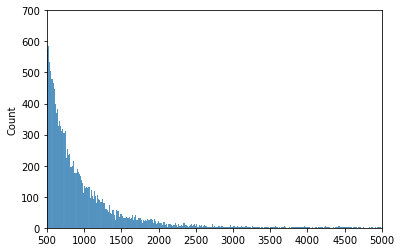

In [7]:
sns.histplot(sl)
plt.ylim(top=700)
plt.xlim((500,5000))
plt.savefig('plot_protsize.png')

In [8]:
curated_data=[]
for n,node in enumerate(proteome_data):
    if len(node['sequence']) < 1500:
        curated_data.append(node)


In [9]:
with open('pickle/curated_sequences.json', 'w') as file:
    json.dump(curated_data, file)


In [10]:
localized=[]
unlocalized=0
unnamed=0
otros_args=[]
hay_otros_args=0
for protein in curated_data:
    try:
        localized.append(protein['localization'])
    except KeyError as e:
        if e.args[0]=='localization':
            unlocalized+=1
        

In [11]:
locations=[]
for location in localized:
    locations+=location
locations=set(locations)

In [12]:
all_descriptors=[]
for location in locations:
    mezza=[]
    mezza_coma=location.split(',')
    for node in mezza_coma:
        mezza+=node.split(';')
    all_descriptors+=mezza
all_descriptors={node.strip() for node in all_descriptors}

In [13]:
colon_descriptor_categories=set()
colon_descriptors=set()
for node in all_descriptors:
    if ':' in node:
        colon_descriptors.add(node.lower())
        parts=node.split(':')
        assert len(parts) <= 2
        colon_descriptor_categories.add(parts[1].strip().lower())
colon_descriptor_categories

{'cell membrane',
 'cell surface',
 'cytoplasm',
 'cytoplasmic vesicle',
 'cytoplasmic vesicle membrane',
 'endomembrane system',
 'endoplasmic reticulum',
 'endoplasmic reticulum membrane',
 'golgi apparatus',
 'golgi apparatus membrane',
 'lysosome',
 'lysosome lumen',
 'membrane',
 'membrane raft',
 'mitochondrion',
 'mitochondrion inner membrane',
 'mitochondrion matrix',
 'mitochondrion membrane',
 'nucleus',
 'secreted',
 'virion'}

In [14]:
urefed_curated_data={}
cnte=0
cnt=0
for node in curated_data:
    try:
        _=node['localization']
        urefed_curated_data[node['uniref100']]=node
        cnt+=1
    except KeyError:
        cnte+=1
        pass

print(cnte,cnt)

50195 23117


In [15]:
with open('pickle/urefed_located_data.json', 'w') as file:
    json.dump(urefed_curated_data, file)

In [16]:
all_keys=[]
for node in curated_data:
    all_keys+=list(node.keys())
count={}
for key in all_keys:
    count[key]=0
for node in curated_data:
    for k in list(node.keys()):
        count[k]+=1
count_of_omniprescence=len(curated_data)
omnipresent_fields=[]
for key, value in count.items():
    if value == count_of_omniprescence:
        omnipresent_fields.append(key)
omnipresent_fields

['uniref100',
 'taxonomy',
 'sequence',
 'organism',
 'proteome',
 'length',
 'acc',
 'uniparc',
 'ncbi_taxon_id']

In [17]:
breaks=0
categorised_data=[]
for key, values in  urefed_curated_data.items():
    for value in values['localization']:
        if value.lower() in colon_descriptors or value.lower() in colon_descriptor_categories: 
            categorised_data.append({
                'uniref100':values['uniref100'],
                'localization':values['localization'],
                'sequence':values['sequence'],
                'cats':{'number':0,
                       'names':[]}
            })
            breaks+=1
            break
       

In [20]:
l_count=0
for key, value in urefed_curated_data.items():
    l_count+=1
    print(value)
    if l_count > 1:
        break

{'uniref100': 'UniRef100_P31946', 'taxonomy': ['Eukaryota', 'Metazoa', 'Chordata', 'Craniata', 'Vertebrata', 'Euteleostomi', 'Mammalia', 'Eutheria', 'Euarchontoglires', 'Primates', 'Haplorrhini', 'Catarrhini', 'Hominidae', 'Homo'], 'sequence': 'MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSVAYKNVVGARRSSWRVISSIEQKTERNEKKQQMGKEYREKIEAELQDICNDVLELLDKYLIPNATQPESKVFYLKMKGDYFRYLSEVASGDNKQTTVSNSQQAYQEAFEISKKEMQPTHPIRLGLALNFSVFYYEILNSPEKACSLAKTAFDEAIAELDTLNEESYKDSTLIMQLLRDNLTLWTSENQGDEGDAGEGEN', 'localization': ['Cytoplasm', 'Melanosome', 'Vacuole membrane'], 'organism': 'Homo sapiens (Human)', 'proteome': 'UP000005640', 'length': 246, 'acc': 'P31946', 'uniref50': 'UniRef50_P31946', 'gene': 'YWHAB', 'name': '14-3-3 protein beta/alpha', 'uniparc': 'UPI000013C714', 'uniref90': 'UniRef90_P31946', 'ptms': {'names': ['N-acetylmethionine; in 14-3-3 protein beta/alpha; alternate', 'N-acetylthreonine; in 14-3-3 protein beta/alpha, N-terminally processed', 'Phosphothreonine', 'N6-acetyllysine', 'N6-ac

In [22]:
import re
val='dato,dato2,datok;datera'
re.split(r",|:|;", val)

['dato', 'dato2', 'datok', 'datera']

In [23]:
breaks=0
categorised_data=[]
for key, values in  urefed_curated_data.items():
    for value in values['localization']:
        for val in re.split(r",|:|;", value): 
            if val.lower() in colon_descriptors or val.lower() in colon_descriptor_categories: 
                categorised_data.append({
                'uniref100':values['uniref100'],
                'localization':values['localization'],
                'sequence':values['sequence'],
                'cats':{'number':0,
                       'names':[]}
                })
            breaks+=1
            break
        break
       

In [24]:
len(categorised_data)

19772

In [25]:
surface=[]
mitochondrion=[]
other=[]
for node in sorted(list(colon_descriptor_categories)):
    if 'mitoch' in node:
        mitochondrion.append(node)
    elif 'cell' in node or 'membrane' in node and 'endo' not in node and 'golgi' not in node and 'cyto' not in node:
        surface.append(node)
    else:
        if 'golgi' in node or 'lyso' in node or 'endop' in node:
            other.append(node)

In [26]:
other, surface, mitochondrion

(['endoplasmic reticulum',
  'endoplasmic reticulum membrane',
  'golgi apparatus',
  'golgi apparatus membrane',
  'lysosome',
  'lysosome lumen'],
 ['cell membrane', 'cell surface', 'membrane', 'membrane raft'],
 ['mitochondrion',
  'mitochondrion inner membrane',
  'mitochondrion matrix',
  'mitochondrion membrane'])

In [27]:
labeled_data={
    'other':{},
    'mitochondrion':{},
    'surface':{}
}
deletable=[]
for datum in categorised_data:
    for value in datum['localization']:
        if value.lower() in other:
            labeled_data['other'][datum['uniref100']]=datum
            datum['cats']['number']+=1
            datum['cats']['names'].append('other')
        if value.lower() in mitochondrion:
            labeled_data['mitochondrion'][datum['uniref100']]=datum
            datum['cats']['number']+=1
            datum['cats']['names'].append('mitochondrion')
        if value.lower() in surface:
            labeled_data['surface'][datum['uniref100']]=datum
            datum['cats']['number']+=1
            datum['cats']['names'].append('surface')
        if datum['cats']['number'] > 1:
            deletable.append(datum)

In [28]:
clean_labeled_data=labeled_data.copy()
for repseq in deletable:
    cats=repseq['cats']['names']
    name=repseq['uniref100']
    for cat in cats:
        try:
            del clean_labeled_data[cat][name]
        except KeyError:
            pass
            #print(cat,name)

In [29]:
with open('pickle/processed_filtered_data.json', 'w') as file:
    json.dump(clean_labeled_data, file)

In [30]:
for k,v in clean_labeled_data.items():
    print('clase {} tiene {} datos'.format(k, len(v)))

clase other tiene 579 datos
clase mitochondrion tiene 789 datos
clase surface tiene 714 datos


In [31]:
mitochondrion_proteins=np.array([protein['sequence'] for uref, protein in clean_labeled_data['mitochondrion'].items() ])
surface_proteins=np.array([protein['sequence'] for uref, protein in clean_labeled_data['surface'].items() ])
all_prot_array=np.hstack([surface_proteins,mitochondrion_proteins])

In [32]:
allseqs=''
for sequence in all_prot_array:
    allseqs+=sequence
aas=set()
for val in allseqs:
    aas.add(val)
numeric_code={aa:num for num,aa in enumerate(aas,3)}
with open('pickle/numeric_code.json', 'w') as file:
    json.dump(numeric_code, file)

In [ ]:
surface_proteins_numeric=[]
for sequence in surface_proteins:
    sequence_array=np.zeros(len(sequence), dtype=int)
    for n,amino_acid in enumerate(sequence):
        sequence_array[n]=numeric_code[amino_acid]
    surface_proteins_numeric.append(sequence_array)
surface_proteins_numeric=np.array(surface_proteins_numeric)
mitochondrion_proteins_numeric=[]
for sequence in mitochondrion_proteins:
    sequence_array=np.zeros(len(sequence), dtype=int)
    for n,amino_acid in enumerate(sequence):
        sequence_array[n]=numeric_code[amino_acid]
    mitochondrion_proteins_numeric.append(sequence_array)
mitochondrion_proteins_numeric=np.array(mitochondrion_proteins_numeric)



In [ ]:
padded_surface_proteins=pad_sequences(surface_proteins_numeric,padding='post', maxlen=1500)
padded_mitochondrion_proteins=pad_sequences(mitochondrion_proteins_numeric,padding='post',maxlen=1500)

In [ ]:
np.save('padded_surface_proteins', padded_surface_proteins)
np.save('padded_mitochondrion_proteins',padded_mitochondrion_proteins)

In [ ]:
padded_surface_proteins.shape, padded_mitochondrion_proteins.shape

In [ ]:
data=np.vstack([padded_surface_proteins, padded_mitochondrion_proteins])

In [ ]:
labels=np.hstack([np.zeros(padded_surface_proteins.shape[0]),np.ones(padded_mitochondrion_proteins.shape[0])]).reshape(-1,1)

In [ ]:
np.savez('preprocessed_data', data=data, labels=labels)